<a href="https://colab.research.google.com/github/LinYuanxi/ML/blob/main/%D0%9C%D0%9C%D0%9E_%D0%9B%D0%A03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Обработка выбросов**

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.datasets import load_boston
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import Image
%matplotlib inline 
sns.set(style="ticks")

In [59]:
data=pd.read_csv('Real estate.csv')

In [60]:
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [61]:
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

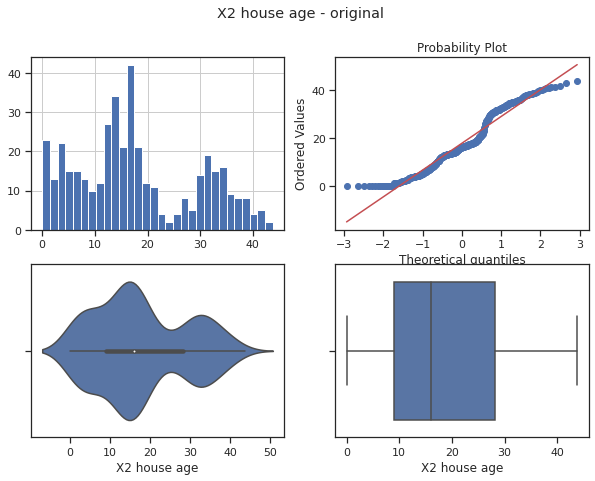

In [62]:
diagnostic_plots(data, 'X2 house age', 'X2 house age - original')

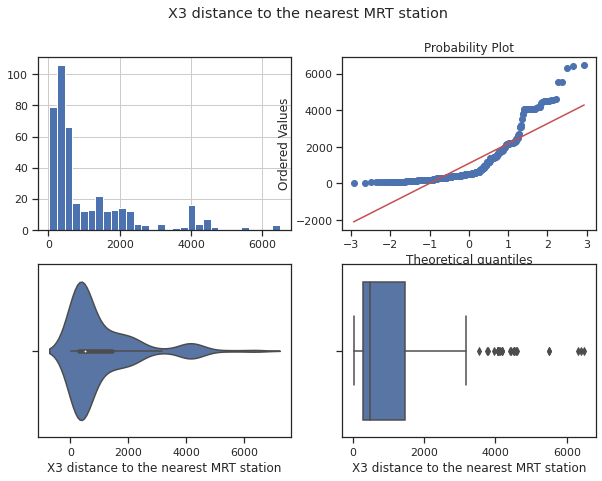

In [63]:
diagnostic_plots(data, 'X3 distance to the nearest MRT station', 'X3 distance to the nearest MRT station')

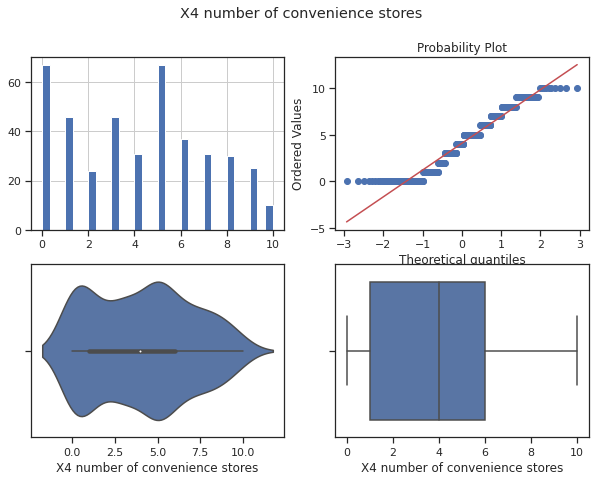

In [64]:
diagnostic_plots(data, 'X4 number of convenience stores', 'X4 number of convenience stores')

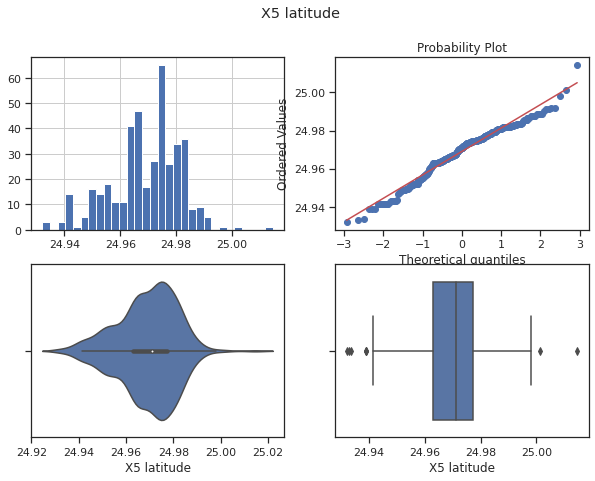

In [65]:
diagnostic_plots(data, 'X5 latitude', 'X5 latitude')

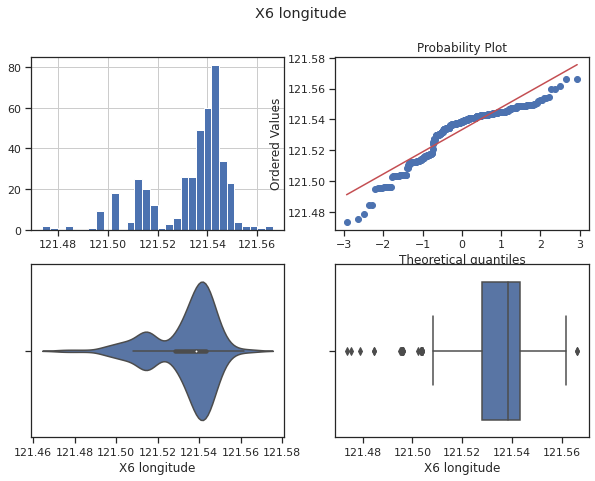

In [66]:
diagnostic_plots(data, 'X6 longitude', 'X6 longitude')

In [67]:
# Тип вычисления верхней и нижней границы выбросов
from enum import Enum
class OutlierBoundaryType(Enum):
    SIGMA = 1
    QUANTILE = 2
    IRQ = 3

In [68]:
# Функция вычисления верхней и нижней границы выбросов
def get_outlier_boundaries(df, col, outlier_boundary_type: OutlierBoundaryType):
    if outlier_boundary_type == OutlierBoundaryType.SIGMA:
        K1 = 3
        lower_boundary = df[col].mean() - (K1 * df[col].std())
        upper_boundary = df[col].mean() + (K1 * df[col].std())

    elif outlier_boundary_type == OutlierBoundaryType.QUANTILE:
        lower_boundary = df[col].quantile(0.05)
        upper_boundary = df[col].quantile(0.95)

    elif outlier_boundary_type == OutlierBoundaryType.IRQ:
        K2 = 1.5
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
        upper_boundary = df[col].quantile(0.75) + (K2 * IQR)

    else:
        raise NameError('Unknown Outlier Boundary Type')
        
    return lower_boundary, upper_boundary 

In [69]:
data.shape

(414, 8)

In [72]:
x_col_list=['X2 house age','X3 distance to the nearest MRT station','X4 number of convenience stores','X5 latitude','X6 longitude']

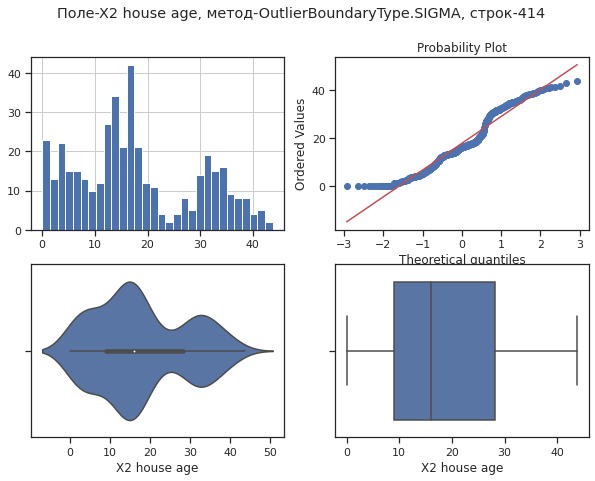

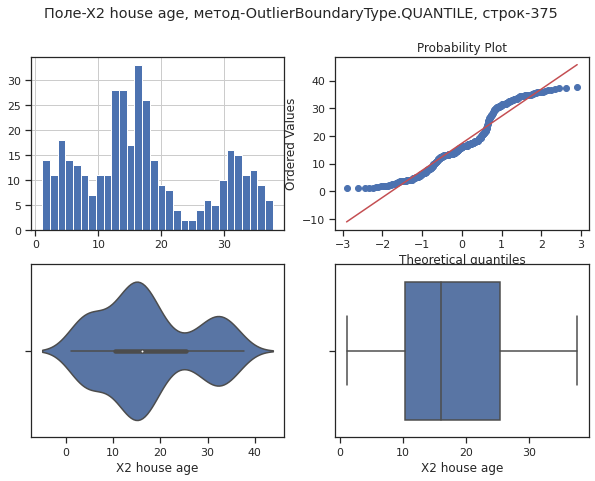

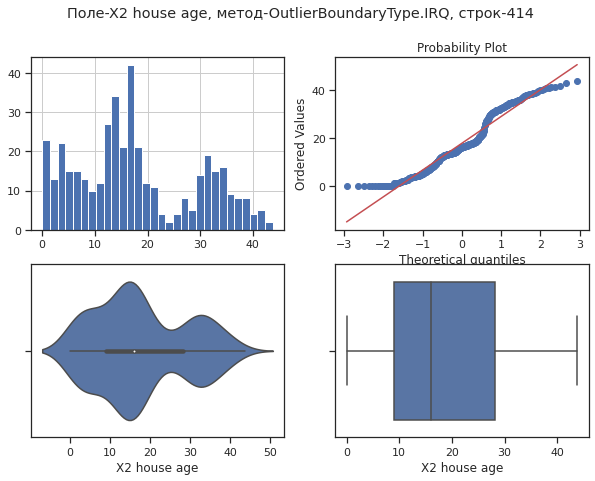

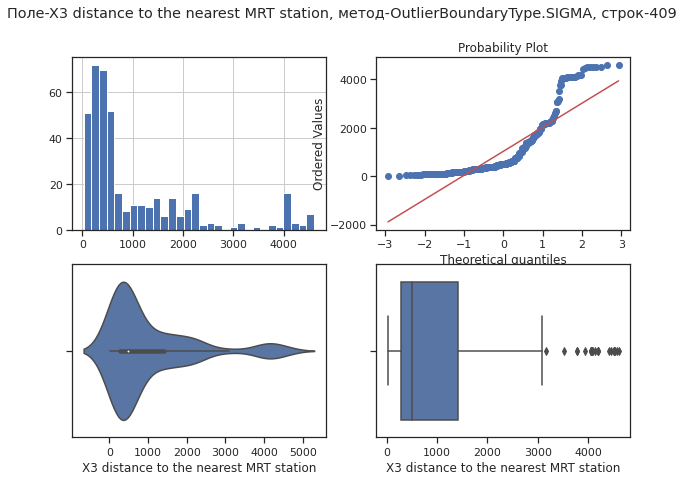

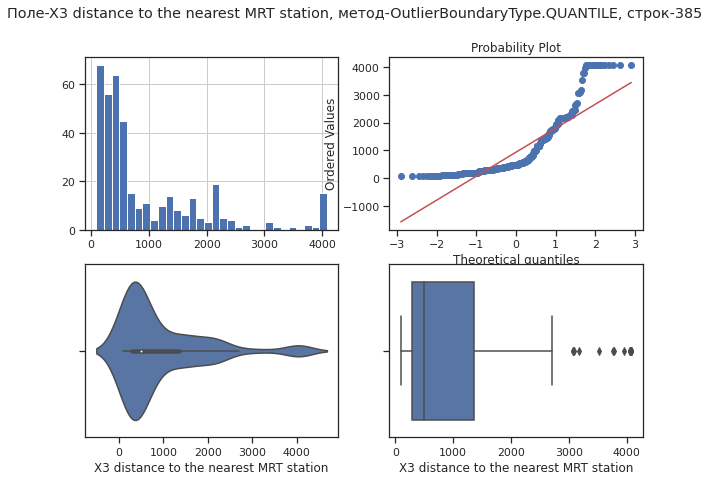

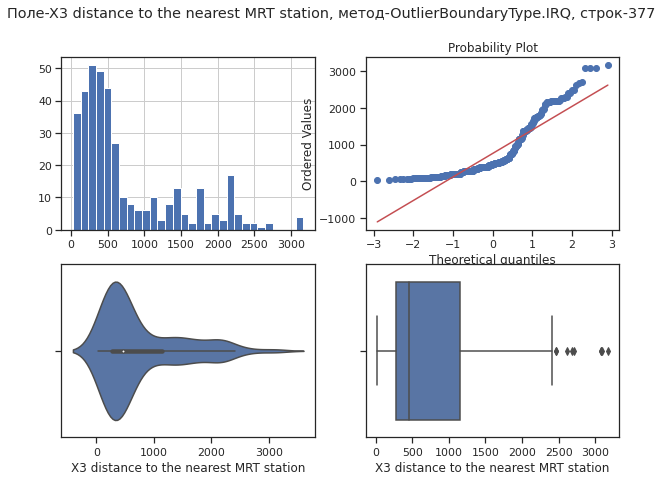

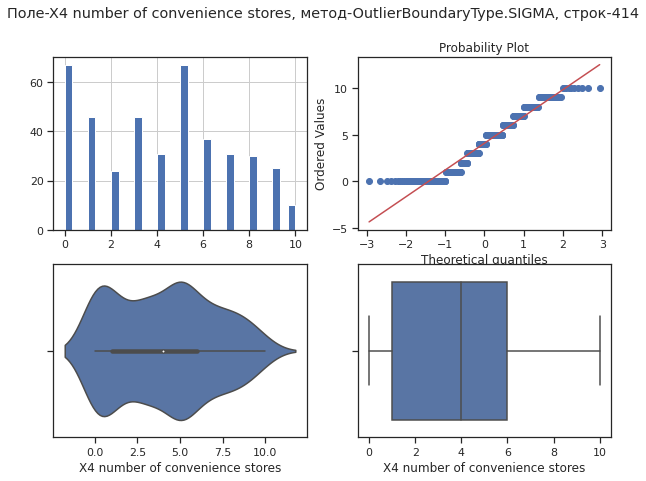

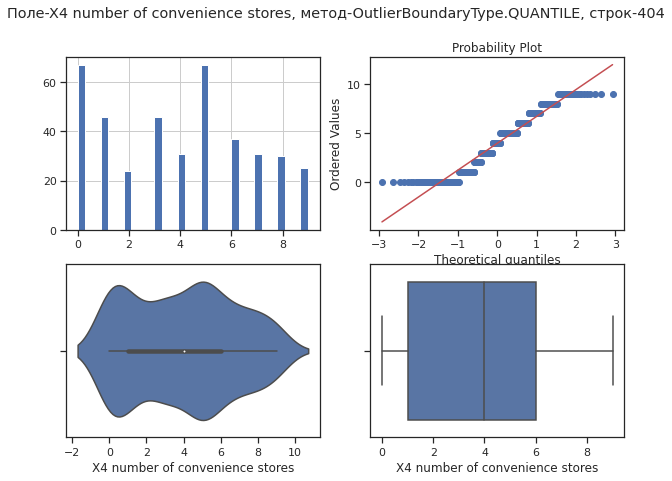

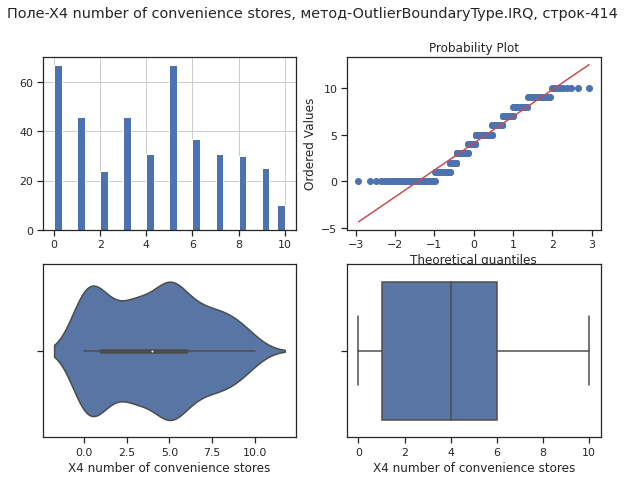

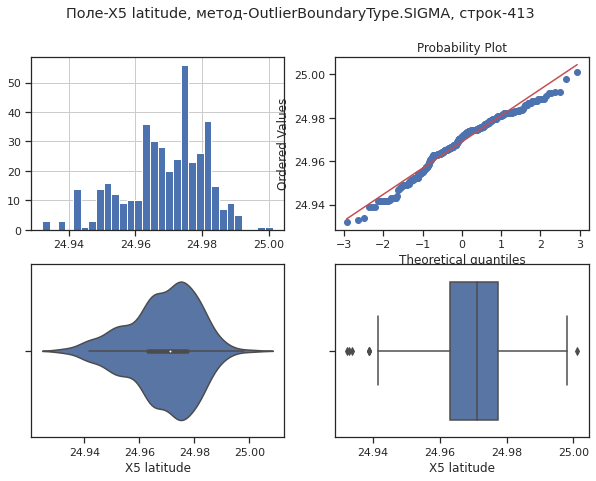

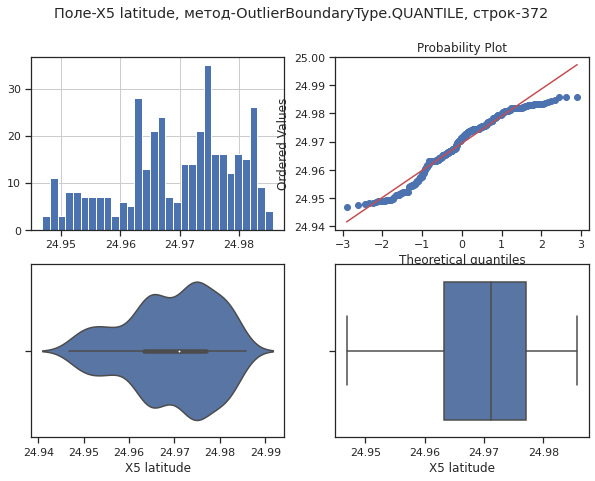

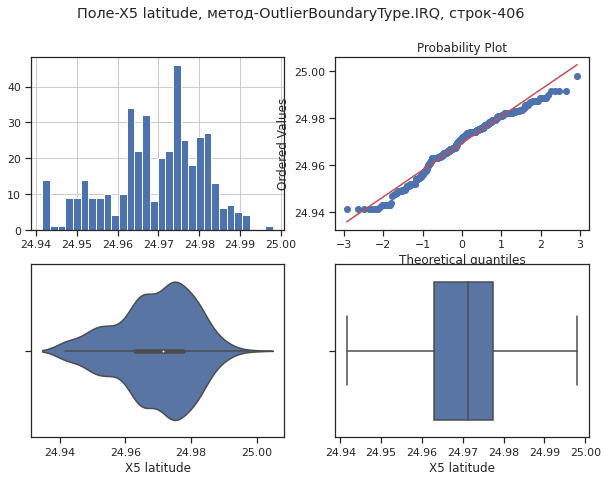

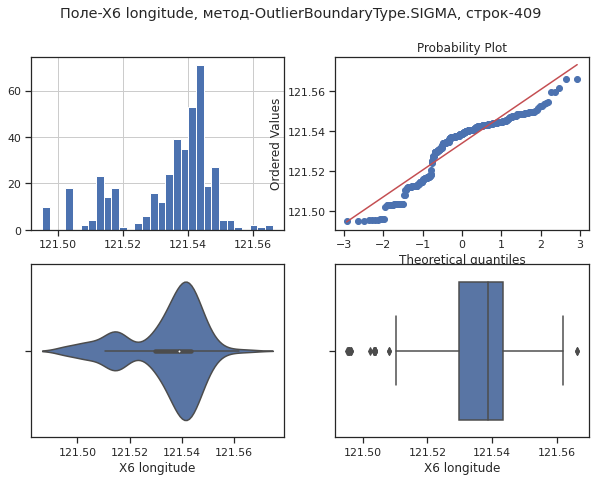

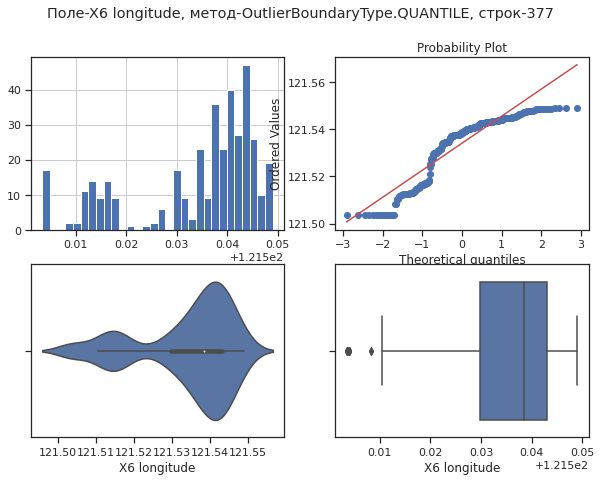

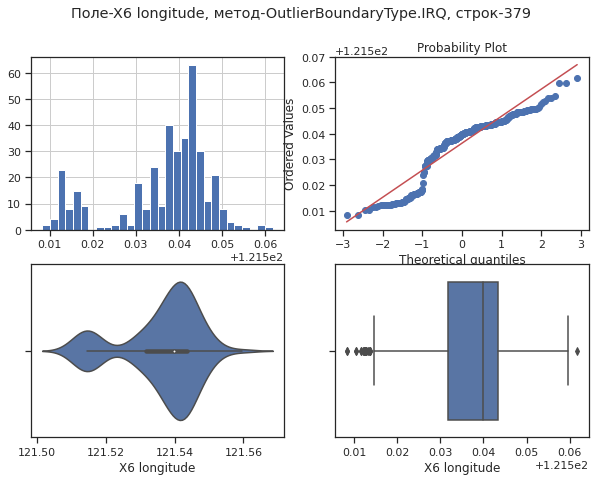

In [73]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Флаги для удаления выбросов
        outliers_temp = np.where(data[col] > upper_boundary, True, 
                                 np.where(data[col] < lower_boundary, True, False))
        # Удаление данных на основе флага
        data_trimmed = data.loc[~(outliers_temp), ]  
        title = 'Поле-{}, метод-{}, строк-{}'.format(col, obt, data_trimmed.shape[0])
        diagnostic_plots(data_trimmed, col, title)

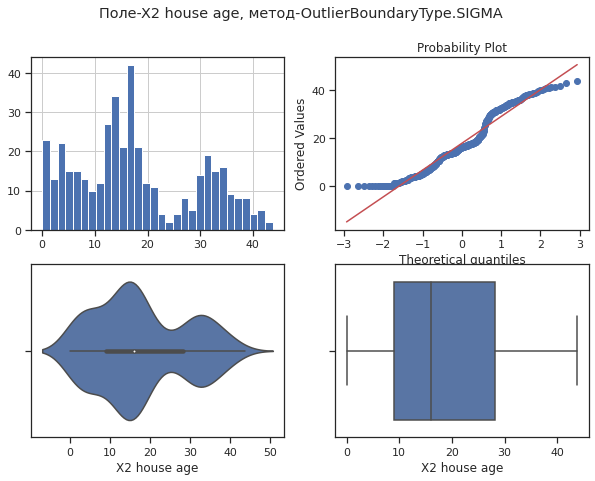

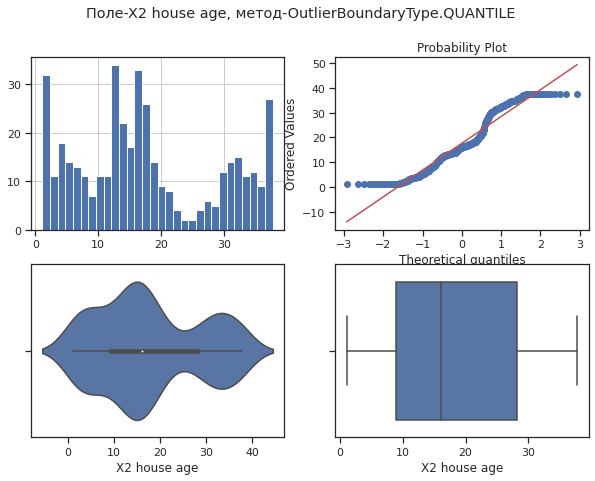

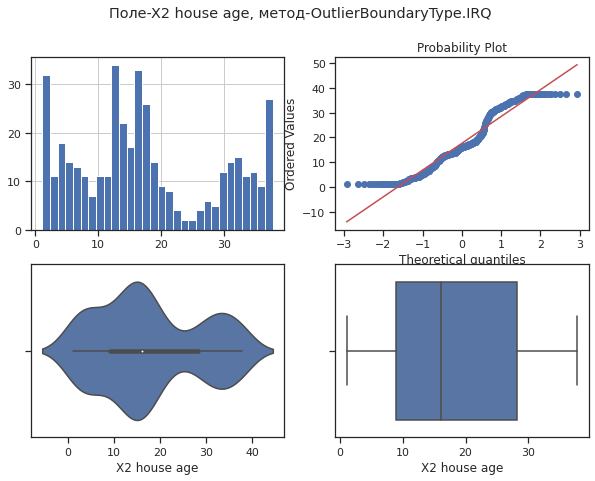

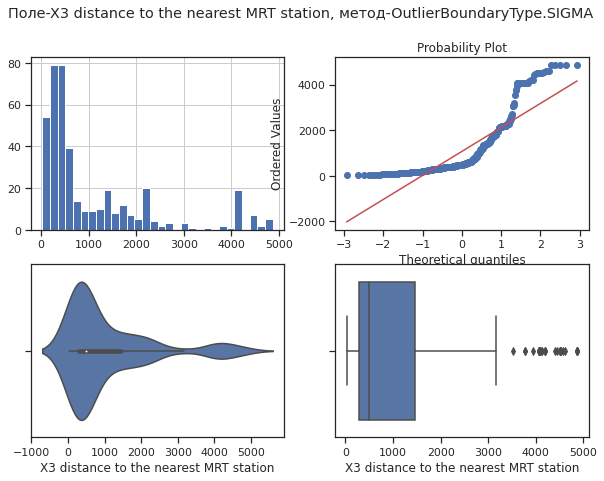

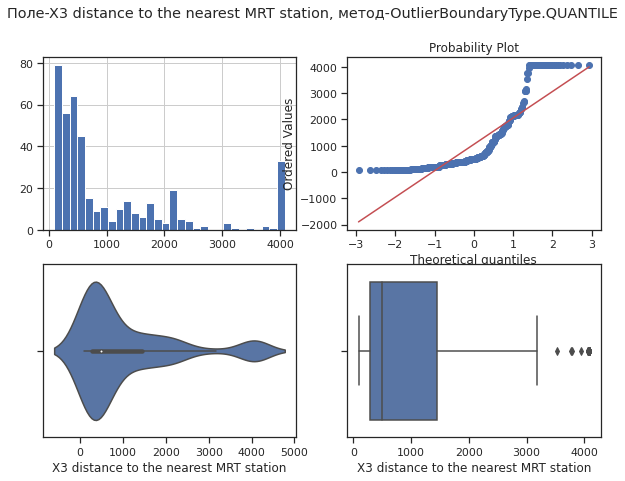

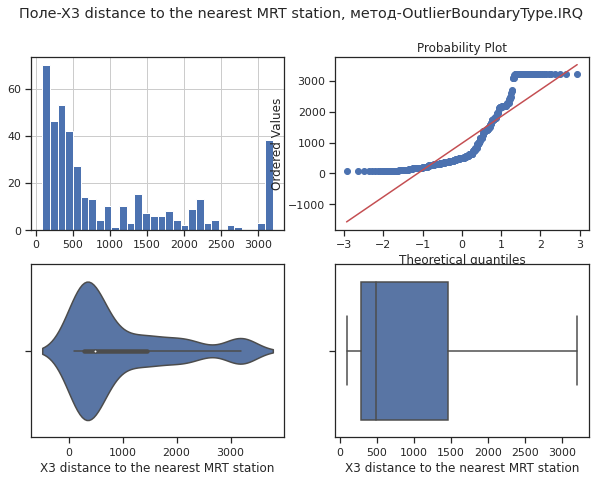

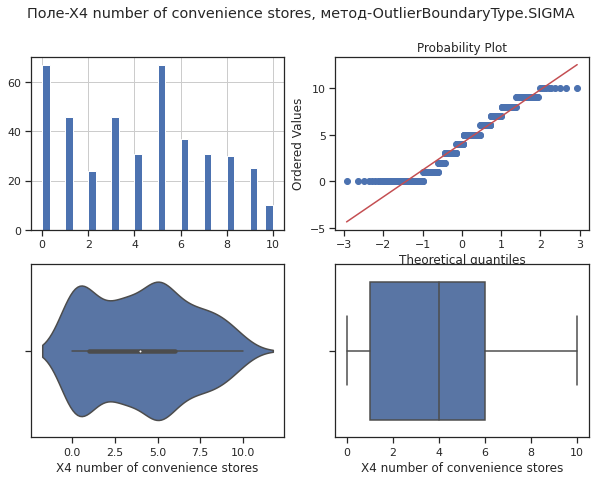

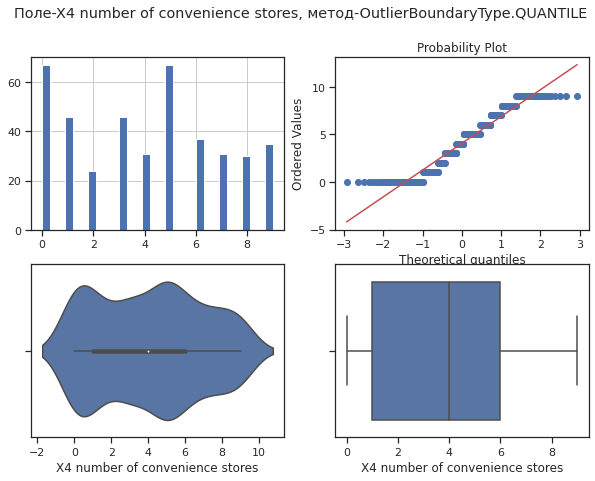

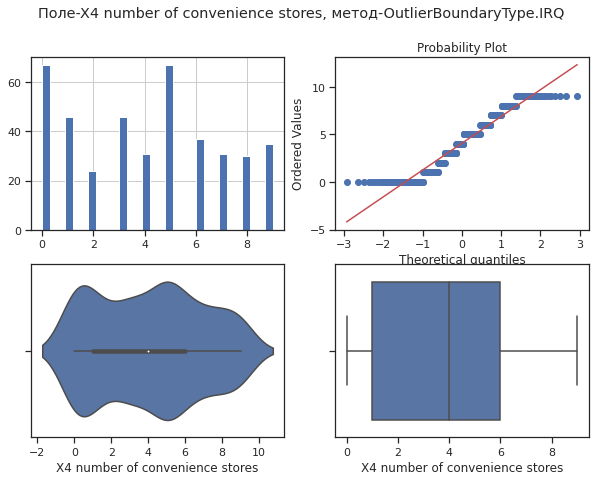

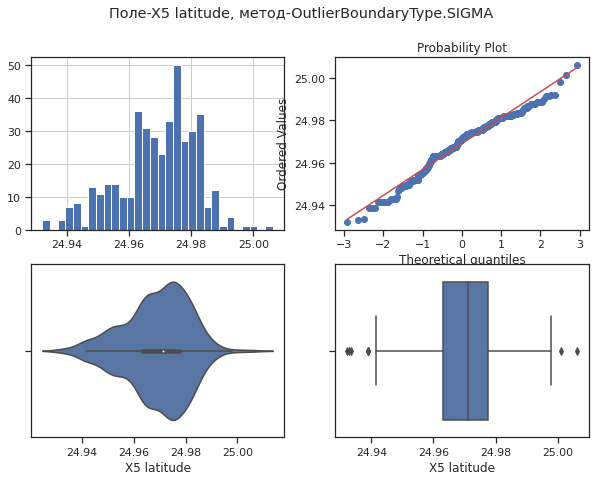

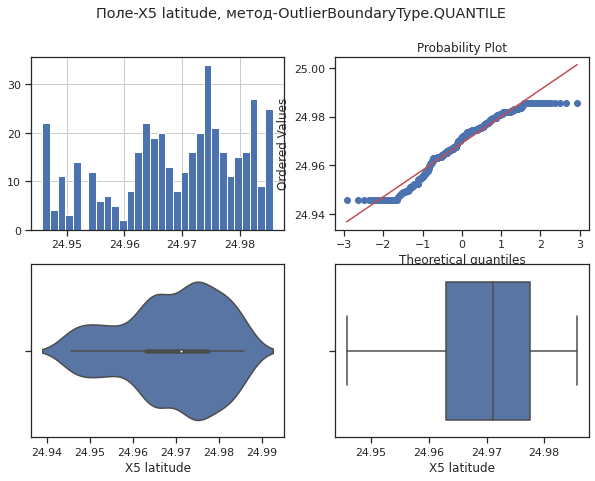

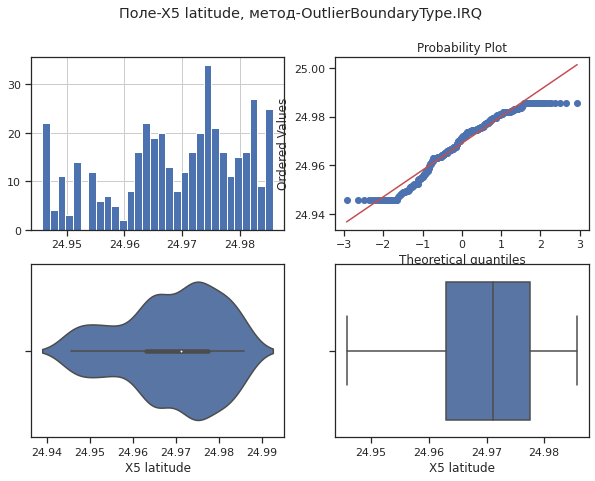

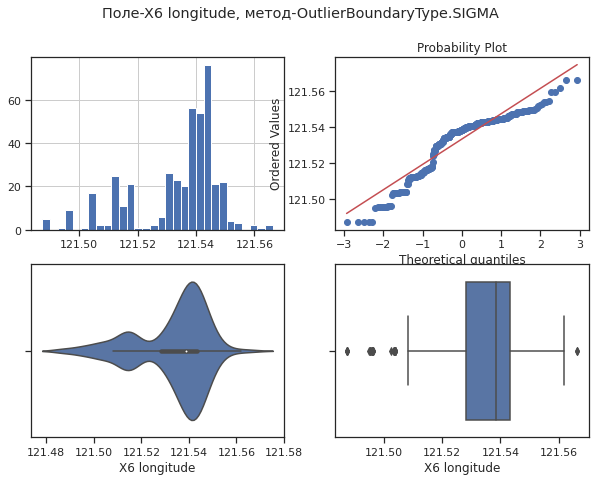

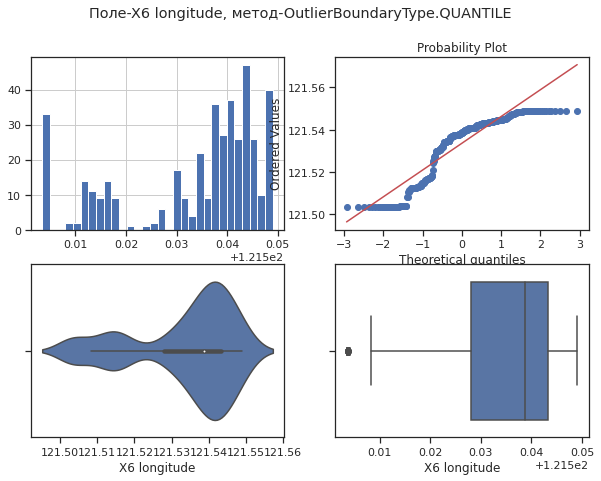

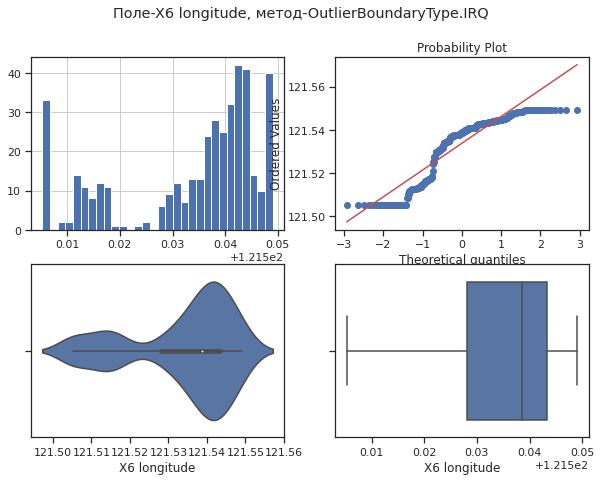

In [74]:
for col in x_col_list:    
    for obt in OutlierBoundaryType:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col, obt)
        # Изменение данных
        data[col] = np.where(data[col] > upper_boundary, upper_boundary, 
                                 np.where(data[col] < lower_boundary, lower_boundary, data[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt)
        diagnostic_plots(data, col, title)

In [75]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [81]:
# DataFrame не содержащий целевой признак
X_ALL = data.drop('Y house price of unit area', axis=1)

# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data['Y house price of unit area'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = pd.DataFrame(X_train, columns=X_ALL.columns)
X_test_df = pd.DataFrame(X_test, columns=X_ALL.columns)

X_train_df.shape, X_test_df.shape

((331, 7), (83, 7))

In [82]:
# Список методов обработки выбросов
method_list = ['Original']

# Список наборов данных
x_train_list = [X_train_df]
y_train_list = [y_train]

In [89]:
# Удаление выбросов
for obt in OutlierBoundaryType:

    df1 = X_train_df.copy()
    df1['Y'] = y_train
    
    # Вычисление верхней и нижней границы
    X2_lower_boundary, X2_upper_boundary = get_outlier_boundaries(df1, 'X2 house age', obt)
    X3_lower_boundary, X3_upper_boundary = get_outlier_boundaries(df1, 'X3 distance to the nearest MRT station', obt)
    X4_lower_boundary, X4_upper_boundary = get_outlier_boundaries(df1, 'X4 number of convenience stores', obt)

    # Флаги для удаления выбросов  
    outliers_X2 = np.where(df1['X2 house age'] > X2_upper_boundary, True, 
                             np.where(df1['X2 house age'] < X2_lower_boundary, True, False))
    outliers_X3 = np.where(df1['X3 distance to the nearest MRT station'] > X3_upper_boundary, True, 
                             np.where(df1['X3 distance to the nearest MRT station'] < X3_lower_boundary, True, False))
    outliers_X4 = np.where(df1['X4 number of convenience stores'] > X4_upper_boundary, True, 
                             np.where(df1['X4 number of convenience stores'] < X4_lower_boundary, True, False))

    # Изменение данных
    data_train_trimmed = df1.loc[~(outliers_X2 + outliers_X3 + outliers_X4), ]
    x_data_train_trimmed = data_train_trimmed.drop('Y', axis=1)
    y_data_train_trimmed = data_train_trimmed['Y']
    title = '{}-trimmed'.format(obt)
    # Сохранение в списки
    method_list.append(title)
    x_train_list.append(x_data_train_trimmed)
    y_train_list.append(y_data_train_trimmed)

In [90]:
# Замена выбросов
for obt in OutlierBoundaryType:
    
    df2 = X_train_df.copy()
    
    for col in x_col_list:    
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(df2, col, obt)
        # Изменение данных
        df2[col] = np.where(df2[col] > upper_boundary, upper_boundary, 
                                 np.where(df2[col] < lower_boundary, lower_boundary, df2[col]))

    title = '{}-updated'.format(obt)
    # Сохранение в списки
    method_list.append(title)
    x_train_list.append(df2)        
    y_train_list.append(y_train)

In [91]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [92]:
def test_models(clas_models_dict, method_list, x_train_list, y_train_list, X_test, y_test):
    logger = MetricLogger()
    for model_name, model in clas_models_dict.items():
        for name, (x_data, y_data) in zip(method_list, zip(x_train_list, y_train_list)):
            model.fit(x_data, y_data)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, name, mse)
    return logger

In [93]:
%%time
logger = test_models(clas_models_dict, method_list, x_train_list, y_train_list, X_test, y_test)

CPU times: user 1.84 s, sys: 636 µs, total: 1.84 s
Wall time: 1.9 s


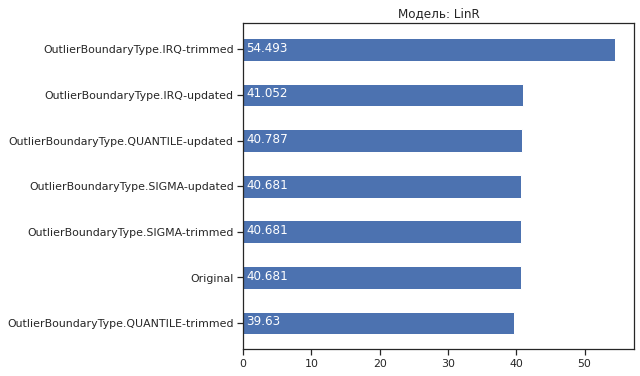

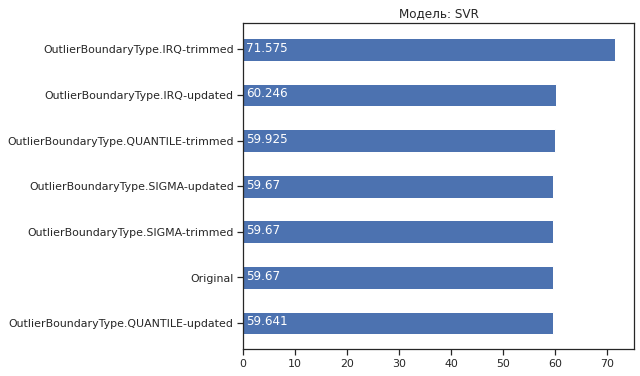

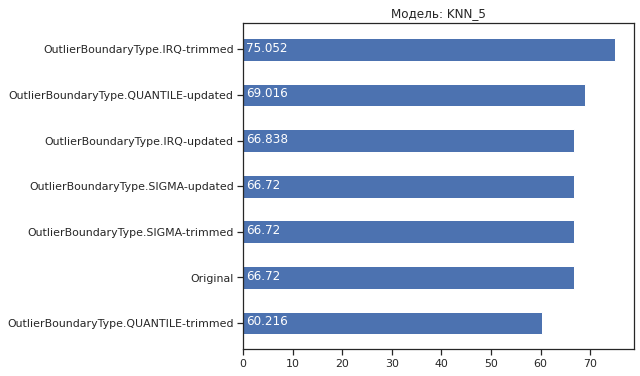

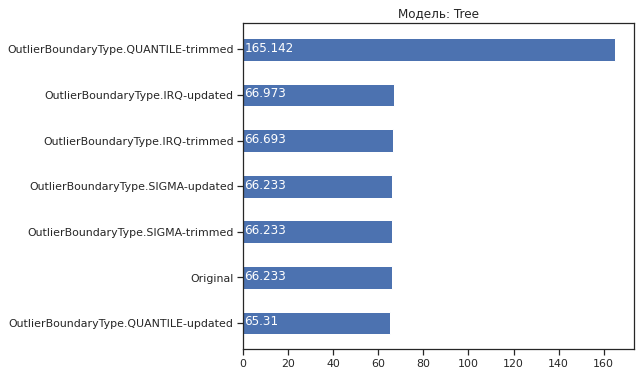

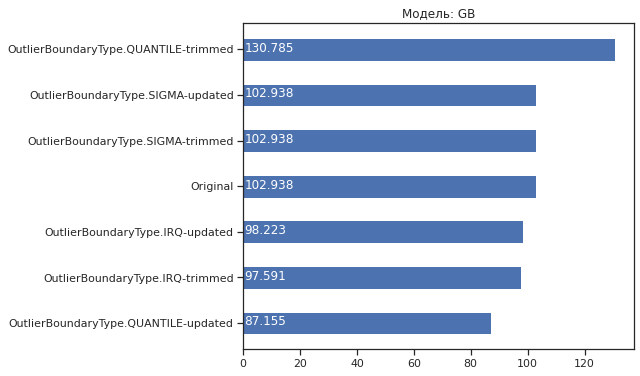

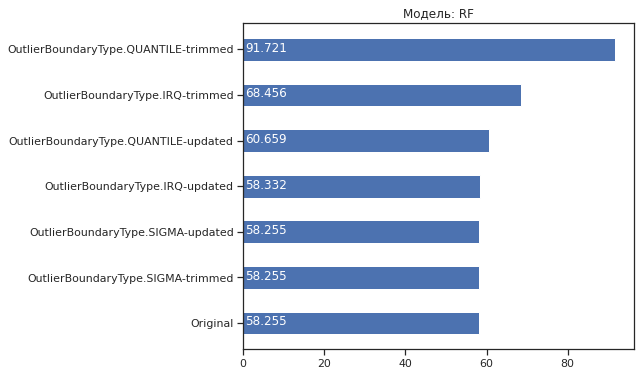

In [94]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

**Масштабирование признаков**

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

In [96]:
data.shape

(414, 8)

In [97]:
data.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,90.45606,9.0,24.982980,121.54024,37.9
1,2,2012.917,19.5,306.59470,9.0,24.980340,121.53951,42.2
2,3,2013.583,13.3,561.98450,5.0,24.985704,121.54391,47.3
3,4,2013.500,13.3,561.98450,5.0,24.985704,121.54391,54.8
4,5,2012.833,5.0,390.56840,5.0,24.979370,121.54245,43.1


In [98]:
# Нужно ли масштабирование
data.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,207.500000,2013.148971,17.655640,975.431960,4.070048,24.969036,121.533735,37.980193
std,119.655756,0.281967,11.125211,968.083398,2.900684,0.011280,0.013415,13.606488
min,1.000000,2012.667000,1.100000,90.456060,0.000000,24.945759,121.505255,7.600000
25%,104.250000,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,207.500000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,310.750000,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,414.000000,2013.583000,37.735000,3201.710300,9.000000,24.985704,121.549053,117.500000


In [100]:
# DataFrame не содержащий целевой признак
X_ALL = data.drop('Y house price of unit area', axis=1)

In [101]:
# Функция для восстановления датафрейма
# на основе масштабированных данных
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=X_ALL.columns)
    return res

In [102]:
# Разделим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_ALL, data['Y house price of unit area'],
                                                    test_size=0.2,
                                                    random_state=1)
# Преобразуем массивы в DataFrame
X_train_df = arr_to_df(X_train)
X_test_df = arr_to_df(X_test)

X_train_df.shape, X_test_df.shape

((331, 7), (83, 7))

Масштабирование данных на основе Z-оценки

In [103]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs11 = StandardScaler()
data_cs11_scaled_temp = cs11.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs11_scaled =  arr_to_df(data_cs11_scaled_temp)
data_cs11_scaled

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,-1.727872,-0.823683,1.290916,-0.915259,1.701639,1.237679,0.485511
1,-1.719505,-0.823683,0.165983,-0.691724,1.701639,1.003356,0.431027
2,-1.711137,1.541151,-0.391984,-0.427595,0.320985,1.479458,0.759421
3,-1.702770,1.246435,-0.391984,-0.427595,0.320985,1.479458,0.759421
4,-1.694402,-1.121951,-1.138940,-0.604877,0.320985,0.917260,0.650454
...,...,...,...,...,...,...,...
409,1.694402,-0.528967,-0.355987,2.302459,-1.404832,-2.066057,-2.125597
410,1.702770,-1.711384,-1.084944,-0.915259,1.701639,0.469915,0.698967
411,1.711137,0.358734,0.102986,-0.604462,1.011312,0.904833,0.457149
412,1.719505,-0.528967,-0.859957,-0.900413,0.320985,-0.203764,0.517604


In [104]:
data_cs11_scaled.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02,4.140000e+02
mean,7.026049e-17,3.705656e-13,1.061952e-16,6.865147e-17,1.609019e-17,2.170743e-13,-1.188747e-12
std,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00,1.001210e+00
min,-1.727872e+00,-1.711384e+00,-1.489920e+00,-9.152586e-01,-1.404832e+00,-2.066057e+00,-2.125597e+00
25%,-8.639361e-01,-8.236832e-01,-7.767118e-01,-7.095848e-01,-1.059668e+00,-5.357221e-01,-4.216787e-01
50%,0.000000e+00,6.401736e-02,-1.399994e-01,-4.997351e-01,-2.417811e-02,1.832242e-01,3.653481e-01
75%,8.639361e-01,9.517179e-01,9.444367e-01,4.952325e-01,6.661487e-01,7.472865e-01,7.142671e-01
max,1.727872e+00,1.541151e+00,1.807036e+00,2.302459e+00,1.701639e+00,1.479458e+00,1.143232e+00


In [105]:
# Построение плотности распределения
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

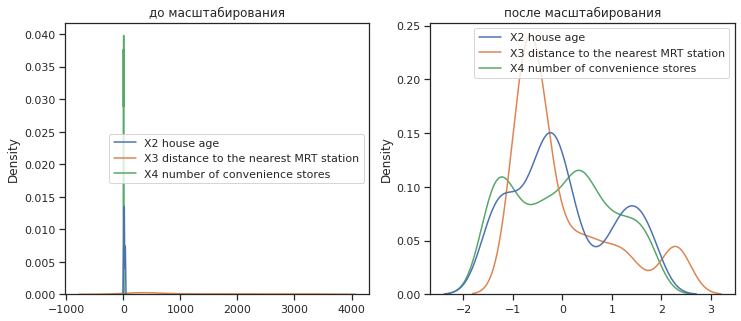

In [107]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data, data_cs11_scaled, 'до масштабирования', 'после масштабирования')

In [108]:
# Обучаем StandardScaler на обучающей выборке 
# и масштабируем обучающую и тестовую выборки
cs12 = StandardScaler()
cs12.fit(X_train)
data_cs12_scaled_train_temp = cs12.transform(X_train)
data_cs12_scaled_test_temp = cs12.transform(X_test)
# формируем DataFrame на основе массива
data_cs12_scaled_train = arr_to_df(data_cs12_scaled_train_temp)
data_cs12_scaled_test = arr_to_df(data_cs12_scaled_test_temp)

In [109]:
data_cs12_scaled_train.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,8.586619e-17,-1.733850e-13,-2.012489e-17,7.043711e-17,7.446209e-17,-6.601836e-14,-8.813279e-13
std,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00,1.001514e+00
min,-1.707890e+00,-1.787258e+00,-1.485227e+00,-9.181102e-01,-1.452974e+00,-2.102376e+00,-2.244540e+00
25%,-8.525193e-01,-8.984358e-01,-7.767940e-01,-7.058954e-01,-1.105478e+00,-5.620650e-01,-3.485772e-01
50%,-1.400307e-02,-9.613247e-03,-1.396500e-01,-4.893720e-01,2.845057e-01,1.550217e-01,3.599100e-01
75%,8.666497e-01,8.792093e-01,1.018794e+00,4.906638e-01,6.320016e-01,8.088622e-01,6.943559e-01
max,1.772584e+00,1.469387e+00,1.779357e+00,2.401939e+00,1.674489e+00,1.455933e+00,1.122793e+00


In [110]:
data_cs12_scaled_test.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.161346,-0.367670,-0.049562,0.130964,-0.192778,-0.143971,-0.273787
std,1.031333,0.956853,0.954751,1.150891,1.024981,1.015836,1.122674
min,-1.674181,-1.787258,-1.485227,-0.918110,-1.452974,-2.102376,-2.244540
25%,-0.768246,-1.197080,-0.781250,-0.722233,-1.105478,-0.567410,-1.389204
50%,0.230389,-0.603347,-0.166383,-0.467691,-0.410486,0.070397,0.151554
75%,1.068905,0.433020,0.617794,0.853004,0.284506,0.530490,0.665140
max,1.764157,1.469387,1.779357,2.401939,1.674489,1.455933,1.122793


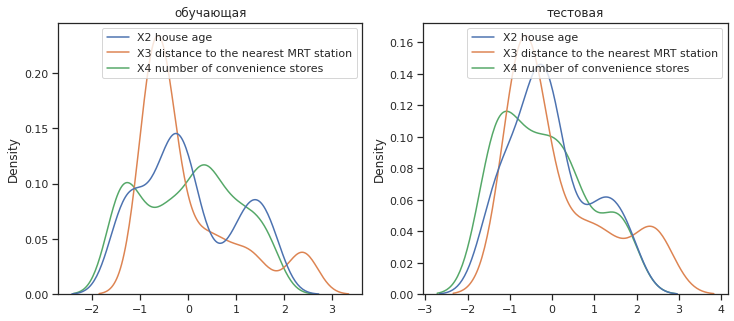

In [111]:
# распределения для обучающей и тестовой выборки немного отличаются
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data_cs12_scaled_train, data_cs12_scaled_test, 'обучающая', 'тестовая')

Масштабирование "Mean Normalisation"

In [112]:
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = X_train.mean(axis=0)
        maxs = X_train.max(axis=0)
        mins = X_train.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [113]:
sc21 = MeanNormalisation()
data_cs21_scaled = sc21.fit_transform(X_ALL)
data_cs21_scaled.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,0.009294,-0.022634,-0.003044,0.007908,-0.012358,-0.008112,-0.016301
std,0.289723,0.307824,0.303677,0.311155,0.322298,0.282388,0.306290
min,-0.490706,-0.548803,-0.454951,-0.276535,-0.464585,-0.590836,-0.666563
25%,-0.240706,-0.275878,-0.238628,-0.212616,-0.353474,-0.159210,-0.145301
50%,0.009294,-0.002952,-0.045507,-0.147399,-0.020141,0.043566,0.095467
75%,0.259294,0.269974,0.283414,0.161816,0.202081,0.202658,0.202208
max,0.509294,0.451197,0.545049,0.723465,0.535415,0.409164,0.333437


In [114]:
cs22 = MeanNormalisation()
cs22.fit(X_train)
data_cs22_scaled_train = cs22.transform(X_train)
data_cs22_scaled_test = cs22.transform(X_test)

In [115]:
data_cs22_scaled_train.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02,3.310000e+02
mean,2.247279e-17,6.913875e-13,2.910562e-16,1.418805e-16,1.241035e-17,2.482797e-13,-5.861962e-13
std,2.877521e-01,3.075293e-01,3.067815e-01,3.016564e-01,3.202321e-01,2.814579e-01,2.974206e-01
min,-4.907061e-01,-5.488034e-01,-4.549514e-01,-2.765351e-01,-4.645854e-01,-5.908358e-01,-6.665631e-01
25%,-2.449434e-01,-2.758777e-01,-2.379458e-01,-2.126160e-01,-3.534743e-01,-1.579585e-01,-1.035173e-01
50%,-4.023321e-03,-2.951886e-03,-4.277726e-02,-1.473990e-01,9.097012e-02,4.356612e-02,1.068828e-01
75%,2.490033e-01,2.699739e-01,3.120747e-01,1.477881e-01,2.020812e-01,2.273165e-01,2.062036e-01
max,5.092939e-01,4.511966e-01,5.450486e-01,7.234649e-01,5.354146e-01,4.091642e-01,3.334369e-01


In [116]:
data_cs22_scaled_test.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,0.046357,-0.112898,-0.015182,0.039446,-0.061640,-0.040460,-0.081307
std,0.296320,0.293816,0.292457,0.346649,0.327736,0.285483,0.333402
min,-0.481021,-0.548803,-0.454951,-0.276535,-0.464585,-0.590836,-0.666563
25%,-0.220730,-0.367581,-0.239311,-0.217537,-0.353474,-0.159461,-0.412553
50%,0.066195,-0.185266,-0.050966,-0.140869,-0.131252,0.019784,0.045007
75%,0.307115,0.132965,0.189241,0.256925,0.090970,0.149085,0.197527
max,0.506873,0.451197,0.545049,0.723465,0.535415,0.409164,0.333437


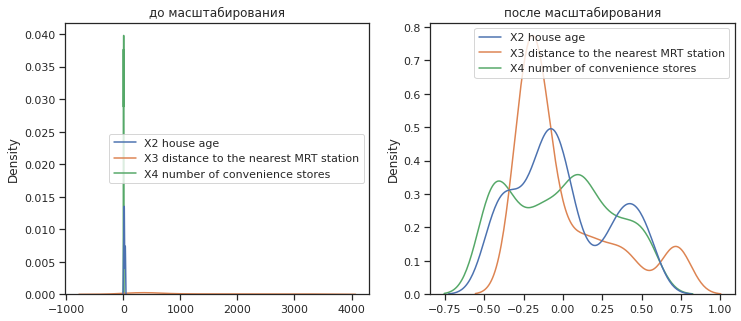

In [121]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data, data_cs21_scaled, 'до масштабирования', 'после масштабирования')

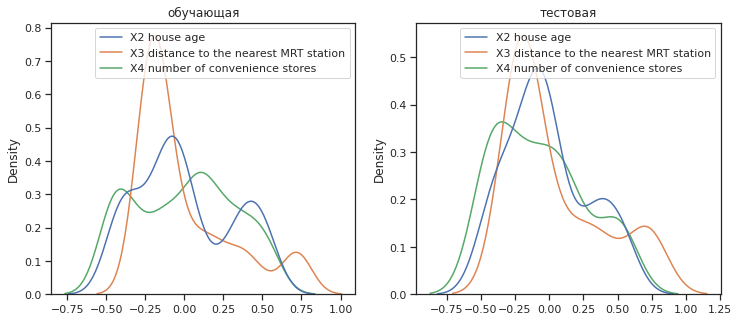

In [122]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data_cs22_scaled_train, data_cs22_scaled_test, 'обучающая', 'тестовая')

MinMax-масштабирование

In [119]:
# Обучаем StandardScaler на всей выборке и масштабируем
cs31 = MinMaxScaler()
data_cs31_scaled_temp = cs31.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs31_scaled = arr_to_df(data_cs31_scaled_temp)
data_cs31_scaled.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,0.500000,0.526169,0.451908,0.284443,0.452228,0.582724,0.650263
std,0.289723,0.307824,0.303677,0.311155,0.322298,0.282388,0.306290
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.272926,0.216323,0.063919,0.111111,0.431626,0.521263
50%,0.500000,0.545852,0.409445,0.129136,0.444444,0.634402,0.762030
75%,0.750000,0.818777,0.738365,0.438351,0.666667,0.793494,0.868771
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [120]:
cs32 = MinMaxScaler()
cs32.fit(X_train)
data_cs32_scaled_train_temp = cs32.transform(X_train)
data_cs32_scaled_test_temp = cs32.transform(X_test)
# формируем DataFrame на основе массива
data_cs32_scaled_train = arr_to_df(data_cs32_scaled_train_temp)
data_cs32_scaled_test = arr_to_df(data_cs32_scaled_test_temp)

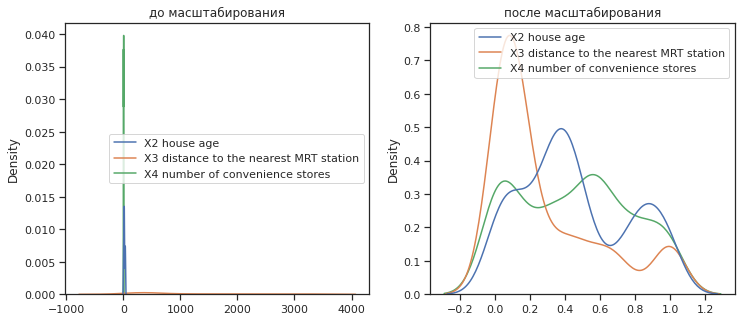

In [123]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data, data_cs31_scaled, 'до масштабирования', 'после масштабирования')

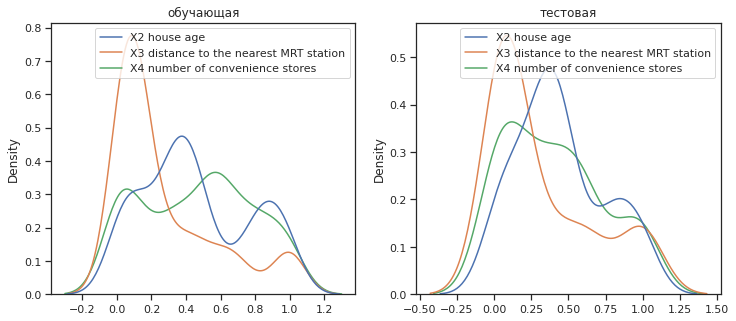

In [124]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data_cs32_scaled_train, data_cs32_scaled_test, 'обучающая', 'тестовая')

Масштабирование по медиане

In [125]:
cs41 = RobustScaler()
data_cs41_scaled_temp = cs41.fit_transform(X_ALL)
# формируем DataFrame на основе массива
data_cs41_scaled = arr_to_df(data_cs41_scaled_temp)
data_cs41_scaled.describe()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
count,4.140000e+02,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.501751e-17,-0.036058,0.081341,0.414781,0.014010,-0.142808,-0.321625
std,5.794468e-01,0.563934,0.581710,0.831006,0.580137,0.780361,0.881389
min,-1.000000e+00,-1.000000,-0.784314,-0.344885,-0.800000,-1.753130,-2.192838
25%,-5.000000e-01,-0.500000,-0.369935,-0.174176,-0.600000,-0.560360,-0.692838
50%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000e-01,0.500000,0.630065,0.825824,0.400000,0.439640,0.307162
max,1.000000e+00,0.832000,1.131242,2.325824,1.000000,1.010308,0.684790


In [126]:
cs42 = RobustScaler()
cs42.fit(X_train)
data_cs42_scaled_train_temp = cs42.transform(X_train)
data_cs42_scaled_test_temp = cs42.transform(X_test)
# формируем DataFrame на основе массива
data_cs42_scaled_train = arr_to_df(data_cs42_scaled_train_temp)
data_cs42_scaled_test = arr_to_df(data_cs42_scaled_test_temp)

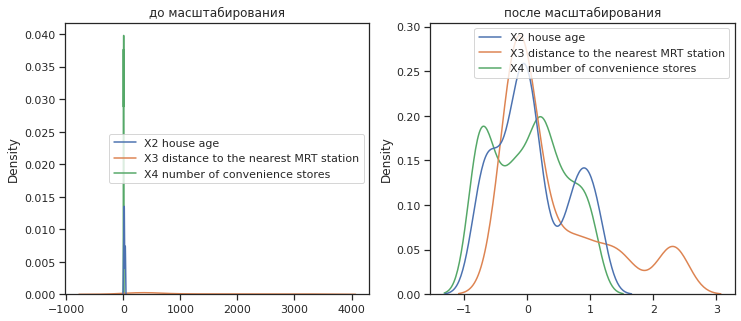

In [127]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data, data_cs41_scaled, 'до масштабирования', 'после масштабирования')

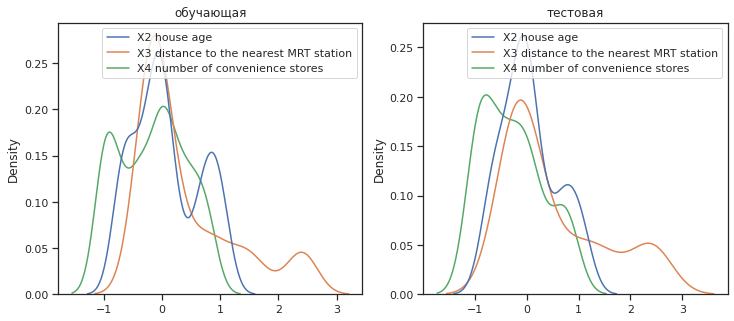

In [128]:
draw_kde(['X2 house age', 'X3 distance to the nearest MRT station', 'X4 number of convenience stores'], data_cs42_scaled_train, data_cs42_scaled_test, 'обучающая', 'тестовая')

In [129]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [131]:
clas_models_dict = {'LinR': LinearRegression(), 
                    'SVR': SVR(),
                    'KNN_5':KNeighborsRegressor(n_neighbors=5),
                    'Tree':DecisionTreeRegressor(random_state=1),
                    'GB': GradientBoostingRegressor(random_state=1),
                    'RF':RandomForestRegressor(n_estimators=50, random_state=1)}

In [132]:
X_data_dict = {'Original': (X_train_df, X_test_df),
               'StandardScaler': (data_cs12_scaled_train, data_cs12_scaled_test), 
               'MeanNormalisation': (data_cs22_scaled_train, data_cs22_scaled_test),
               'MinMaxScaler': (data_cs32_scaled_train, data_cs32_scaled_test), 
               'RobustScaler': (data_cs42_scaled_train, data_cs42_scaled_test),
               }

In [133]:
def test_models(clas_models_dict, X_data_dict, y_train, y_test):
    
    logger = MetricLogger()
    
    for model_name, model in clas_models_dict.items():
        
        for data_name, data_tuple in X_data_dict.items():

            X_train, X_test = data_tuple
              
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            logger.add(model_name, data_name, mse)
            
    return logger

In [134]:
%%time
logger = test_models(clas_models_dict, X_data_dict, y_train, y_test)

CPU times: user 1.6 s, sys: 4.65 ms, total: 1.6 s
Wall time: 1.68 s


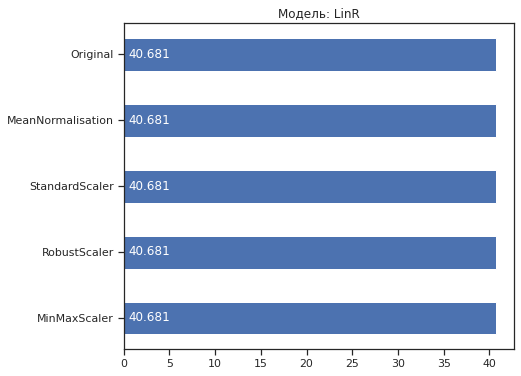

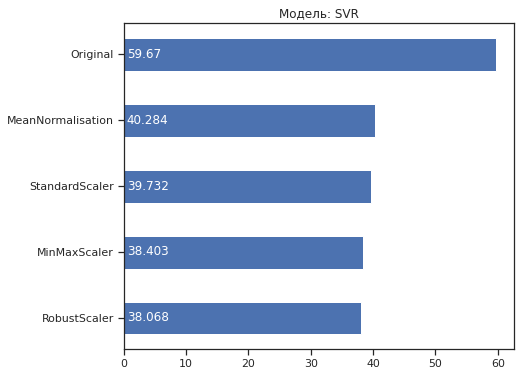

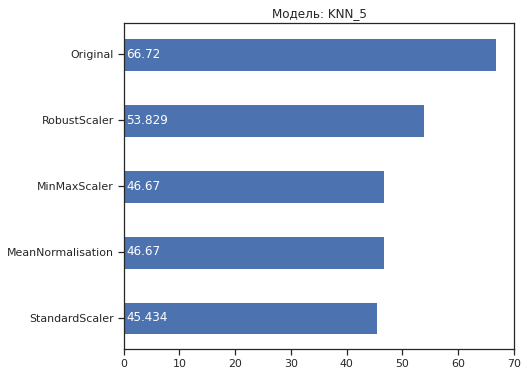

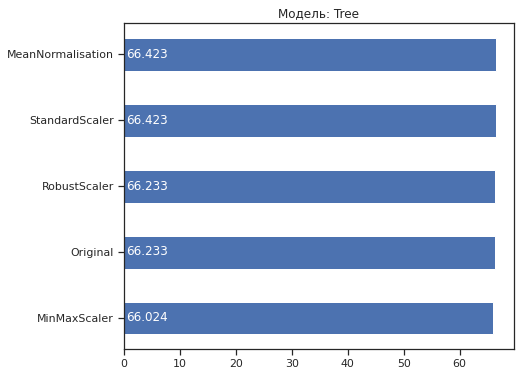

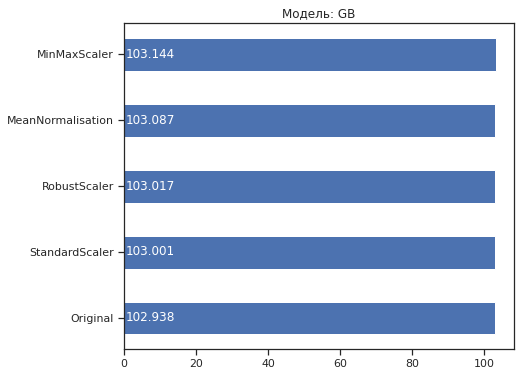

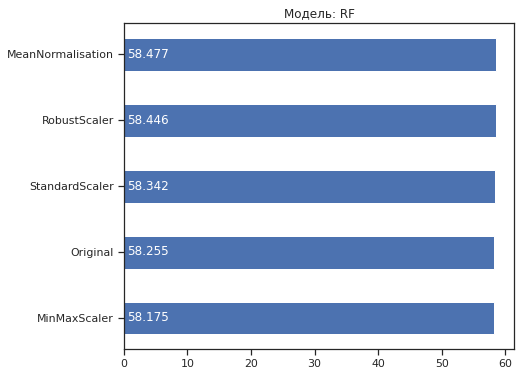

In [135]:
# Построим графики метрик качества модели
for model in clas_models_dict:
    logger.plot('Модель: ' + model, model, figsize=(7, 6))

**Особенности формирования признаков для данных различных типов**

In [137]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import ipaddress
import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [169]:
data = pd.read_csv('athletes.csv', sep=',')

In [170]:
data.shape

(2897, 14)

In [172]:
data.head()

,name,short_name,gender,birth_date,birth_place,birth_country,country,country_code,discipline,discipline_code,residence_place,residence_country,height_m/ft,url
0,AAGAARD Mikkel,AAGAARD M,Male,1995-10-18,FREDERIKSHAVN,Denmark,Denmark,DEN,Ice Hockey,IHO,ORNSKOLDSVIK,Sweden,1.84/6'0'',../../../en/results/ice-hockey/athlete-profile...
1,AALTO Antti,AALTO A,Male,1995-04-02,KITEE,Finland,Finland,FIN,Ski Jumping,SJP,KUOPIO,Finland,NaN,../../../en/results/ski-jumping/athlete-profil...
2,AALTONEN Miro,AALTONEN M,Male,1993-06-07,JOENSUU,Finland,Finland,FIN,Ice Hockey,IHO,PODOLSK,Russian Federation,1.80/5'10'',../../../en/results/ice-hockey/athlete-profile...
3,ABDELKADER Justin,ABDELKADER J,Male,1987-02-25,"MUSKEGON, MI",United States of America,United States of America,USA,Ice Hockey,IHO,"GRAND RAPIDS, MI",United States of America,1.87/6'1'',../../../en/results/ice-hockey/athlete-profile...
4,ABDI Fayik,ABDI F,Male,1997-10-07,"SAN DIEGO, CA",United States of America,Saudi Arabia,KSA,Alpine Skiing,ALP,DHAHRAN,Saudi Arabia,NaN,../../../en/results/alpine-skiing/athlete-prof...


In [173]:
data.dtypes

name                 object
short_name           object
gender               object
birth_date           object
birth_place          object
birth_country        object
country              object
country_code         object
discipline           object
discipline_code      object
residence_place      object
residence_country    object
height_m/ft          object
url                  object
dtype: object

Обработка даты и времени

In [174]:
# Проверка наличия подстроки в URL
def substr_in_url(substr):
    lsubstr = substr.lower()
    return data.apply(lambda x: 1 if lsubstr in x['url'].lower() else 0, axis=1)

In [175]:
data['is_ice-hockey'] = substr_in_url('ice-hockey')
data['is_ski-jumping'] = substr_in_url('ski-jumping')
data['alpine-skiing'] = substr_in_url('alpine-skiing')
data['is_freestyle-skiing'] = substr_in_url('freestyle-skiing')


url_features = ['is_ice-hockey', 'is_men','is_alpine-skiing','is_freestyle-skiing']

In [188]:
data.head()

,name,short_name,gender,birth_date,birth_place,birth_country,country,country_code,discipline,discipline_code,residence_place,residence_country,height_m/ft,url,is_ice-hockey,is_ski-jumping,alpine-skiing,is_freestyle-skiing
0,AAGAARD Mikkel,AAGAARD M,Male,1995-10-18,FREDERIKSHAVN,Denmark,Denmark,DEN,Ice Hockey,IHO,ORNSKOLDSVIK,Sweden,1.84/6'0'',../../../en/results/ice-hockey/athlete-profile...,1,0,0,0
1,AALTO Antti,AALTO A,Male,1995-04-02,KITEE,Finland,Finland,FIN,Ski Jumping,SJP,KUOPIO,Finland,NaN,../../../en/results/ski-jumping/athlete-profil...,0,1,0,0
2,AALTONEN Miro,AALTONEN M,Male,1993-06-07,JOENSUU,Finland,Finland,FIN,Ice Hockey,IHO,PODOLSK,Russian Federation,1.80/5'10'',../../../en/results/ice-hockey/athlete-profile...,1,0,0,0
3,ABDELKADER Justin,ABDELKADER J,Male,1987-02-25,"MUSKEGON, MI",United States of America,United States of America,USA,Ice Hockey,IHO,"GRAND RAPIDS, MI",United States of America,1.87/6'1'',../../../en/results/ice-hockey/athlete-profile...,1,0,0,0
4,ABDI Fayik,ABDI F,Male,1997-10-07,"SAN DIEGO, CA",United States of America,Saudi Arabia,KSA,Alpine Skiing,ALP,DHAHRAN,Saudi Arabia,NaN,../../../en/results/alpine-skiing/athlete-prof...,0,0,1,0


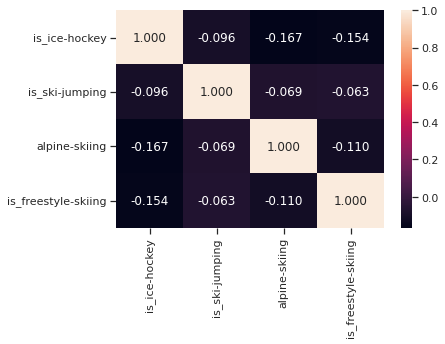

In [201]:
sns.heatmap(data.corr(), annot=True, fmt='.3f')